<a href="https://colab.research.google.com/github/vikaskapur/MyKaggle/blob/master/deep_contextual_mab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
def running_mean(data,window=50):
    c = data.shape[0] - window
    smoothened = np.zeros(c)
    conv = np.ones(window)
    for i in range(c):
        smoothened[i] = (data[i:i+window] @ conv)/window
    return smoothened

In [ ]:
def one_hot_encode(pos, dim):
  vec = np.zeros(dim)
  vec[pos] = 1
  return vec

In [ ]:
print(one_hot_encode(0,4))
print(one_hot_encode(1,4))
print(one_hot_encode(2,4))
print(one_hot_encode(3,4))

[1. 0. 0. 0.]
[0. 1. 0. 0.]
[0. 0. 1. 0.]
[0. 0. 0. 1.]


In [ ]:
def softmax(data, tau=1.2):
  softm = np.exp(data/tau) / np.sum(np.exp(data/tau))
  return softm

In [ ]:
print(softmax(np.array([1,2,1,1])))

[0.18864451 0.43406647 0.18864451 0.18864451]


In [ ]:
class Environment(object):

  def __init__(self, arms):
    self.arms = arms 
    self.reward_probas = np.random.rand(arms, arms)
    self._update_state()

  def _update_state(self):
    self.state = np.random.randint(0, self.arms)

  def get_state(self):
    return self.state 

  def _get_reward(self, arm):
    state = self.get_state()
    prob = self.reward_probas[state][arm]
    rewards = [1 if np.random.random() < prob else 0 for _ in range(self.arms)]
    return sum(rewards)

  def choose_arm(self, arm):
    reward = self._get_reward(arm)
    self._update_state()
    return reward


In [ ]:
env = Environment(arms=5)

In [ ]:
print(env.reward_probas)

[[0.40840362 0.78948451 0.58262317 0.967559   0.39736286]
 [0.90023499 0.61026421 0.938922   0.43315839 0.33174   ]
 [0.80548122 0.15693891 0.198406   0.38975242 0.21790331]
 [0.83115212 0.6369255  0.20240554 0.28259552 0.07689023]
 [0.23428126 0.19056088 0.66087169 0.36243125 0.41522338]]


In [ ]:
state = env.get_state()
print(state)

4


In [ ]:
env.choose_arm(2)

2

In [ ]:
print(env.get_state())

2


In [ ]:
n_arms = 10
n_actions = 10
model = nn.Sequential(
    nn.Linear(n_arms, 100),
    nn.ReLU(),
    nn.Linear(100, n_actions),
    nn.ReLU()
)

In [ ]:
print(model)

Sequential(
  (0): Linear(in_features=10, out_features=100, bias=True)
  (1): ReLU()
  (2): Linear(in_features=100, out_features=10, bias=True)
  (3): ReLU()
)


In [ ]:
def train_network(environ, net, epochs=8000, lr=1e-2):
  optimizer = optim.Adam(net.parameters(), lr=lr)
  criterion = nn.MSELoss()
  rewards = []
  losses = []
  for e in range(1, epochs + 1):
    state = torch.Tensor(one_hot_encode(environ.get_state(), dim=n_arms))
    rewards_pred = net(state)
    action_probas = softmax(rewards_pred.data.numpy().copy())

    arm = np.random.choice(n_arms, p=action_probas)
    reward = environ.choose_arm(arm)
    rewards.append(reward)

    true_rewards = rewards_pred.data.numpy().copy()
    true_rewards[arm] = reward 

    loss = criterion(rewards_pred, torch.Tensor(true_rewards))
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return (np.array(losses), np.array(rewards))



In [ ]:
env = Environment(arms=n_arms)
print(f"CURRENT STATE : {env.get_state()}")
print(env.reward_probas)

CURRENT STATE : 4
[[0.83754601 0.1294537  0.81251155 0.27113647 0.64309394 0.82346569
  0.49893184 0.65983895 0.27654883 0.92499264]
 [0.97491409 0.85521934 0.86135612 0.87643326 0.28679507 0.26809373
  0.22064093 0.9510014  0.84835402 0.33388456]
 [0.38989501 0.91791274 0.09586717 0.68333419 0.9282401  0.24264378
  0.27326672 0.08946298 0.88339061 0.61350482]
 [0.71638265 0.2014948  0.64489675 0.03492986 0.34281327 0.42949956
  0.80786787 0.14387585 0.63613947 0.62647055]
 [0.44499831 0.46900423 0.4666924  0.47191988 0.84924094 0.04762401
  0.7756191  0.50858479 0.12145664 0.95921849]
 [0.96239702 0.40133576 0.0514459  0.05820731 0.0445651  0.99137502
  0.50334006 0.72654482 0.34570477 0.29486076]
 [0.13673244 0.39437039 0.93649872 0.03557291 0.42204239 0.62438257
  0.39569144 0.16081449 0.54638144 0.9485394 ]
 [0.24138505 0.70453014 0.13101263 0.7230592  0.65561072 0.56011602
  0.94812071 0.59547966 0.82856536 0.43440932]
 [0.93993234 0.54473415 0.76461106 0.02136257 0.55664383 0.881

In [ ]:
losses, rewards = train_network(env, model)

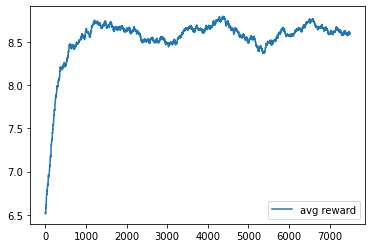

In [ ]:
plt.plot(running_mean(rewards, window=500), label="avg reward")
plt.legend()

In [ ]:
state = torch.Tensor(one_hot_encode(5, dim=10))
preds = model(state)
print(preds)

tensor([ 5.2588,  0.0000,  3.1236,  0.0000,  7.9822,  0.0000,  0.8561, 10.2386,
         3.8589,  9.3666], grad_fn=<ReluBackward0>)
